In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans

## Data Exploration and Preprocessing

1. Loading and Exploring the Dataset

In [18]:
df = pd.read_csv('./diamonds.csv')

df.info()
df.describe()
df.head()
df.drop(df.columns[0], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


2. Handling Missing Values

In [19]:
# check if has null values in dataset
print(df.isnull().sum())

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


3. Categorical to Numerical Conversion

In [20]:
# use one-hot encoding
data_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

4. Target Feature

In [21]:
y = data_encoded['price']

5. Data Visualization

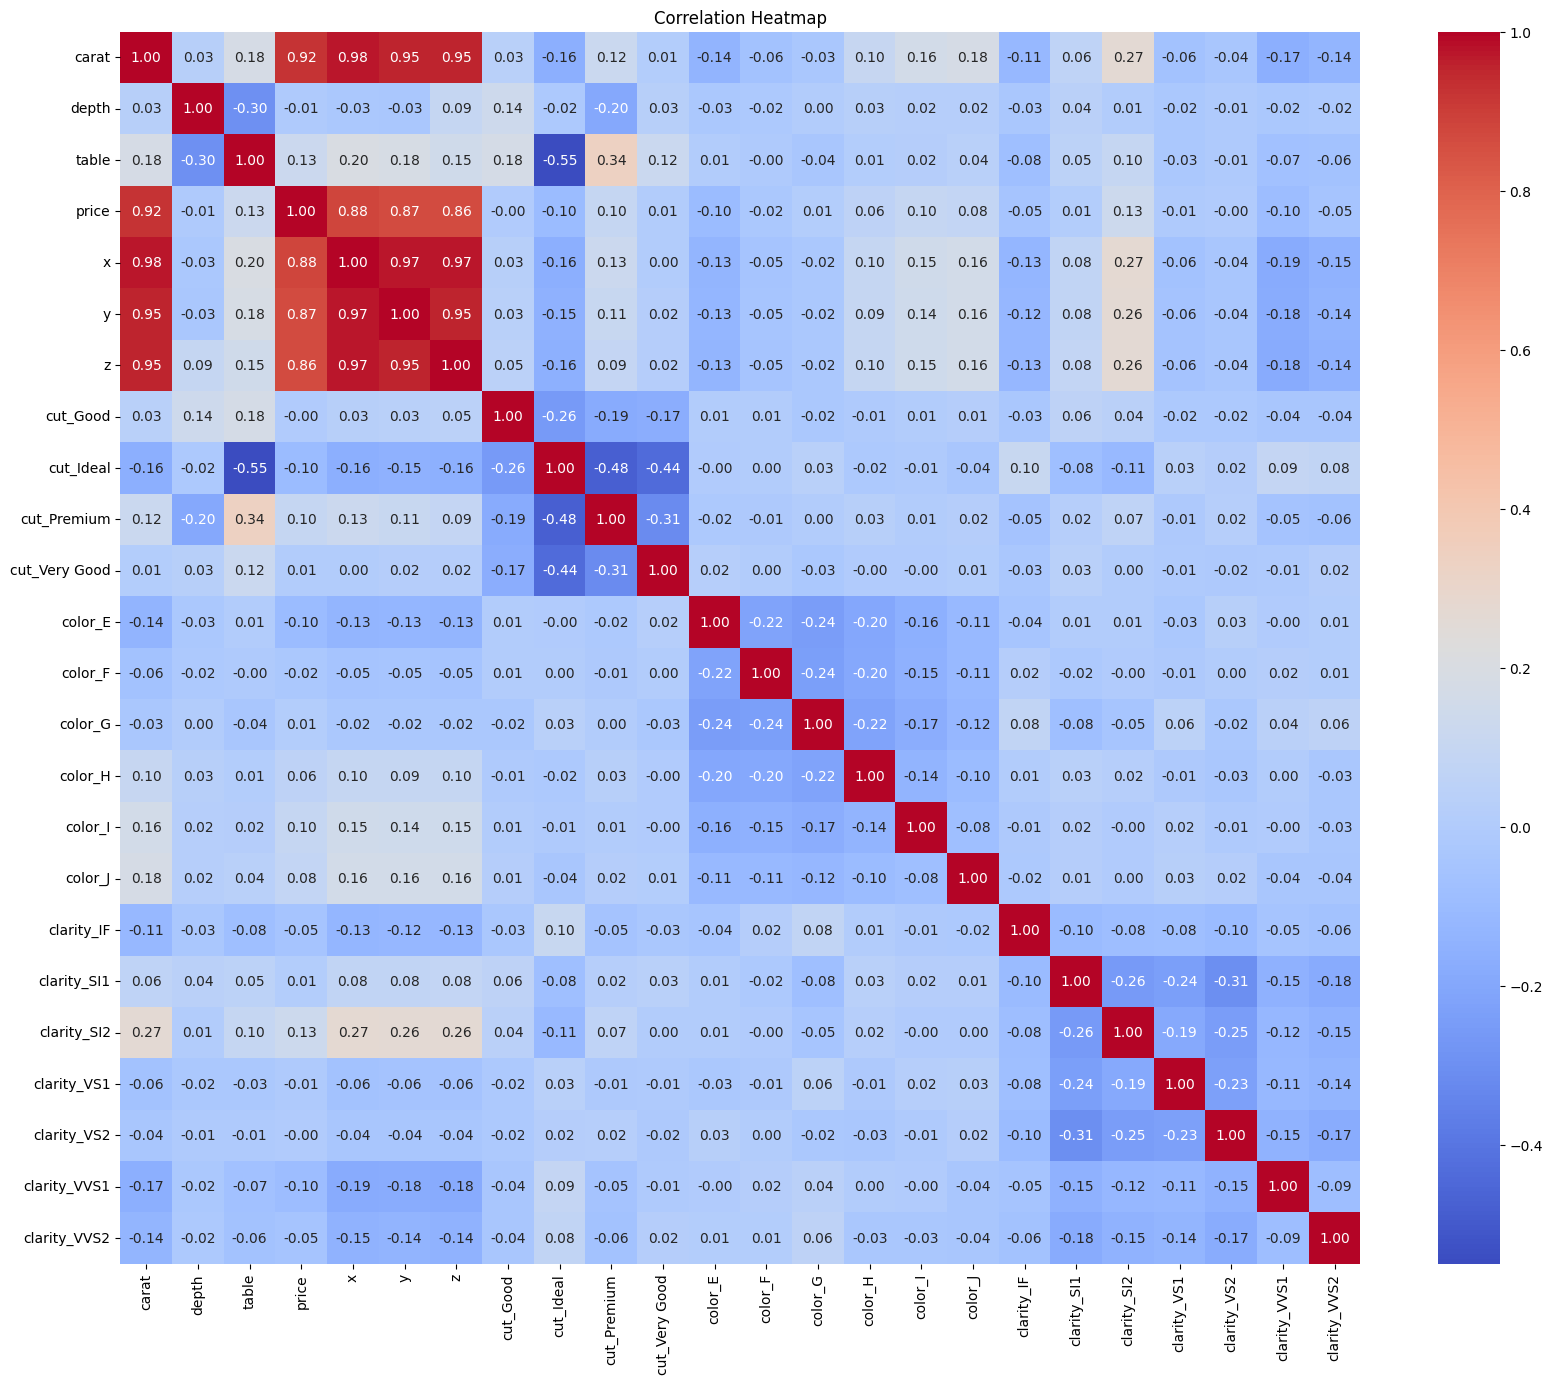

carat            0.921591
x                0.884435
y                0.865421
z                0.861249
clarity_SI2      0.128420
table            0.127134
color_I          0.097125
cut_Premium      0.095706
color_J          0.081710
color_H          0.059223
clarity_SI1      0.008957
color_G          0.008556
cut_Very Good    0.006593
cut_Good        -0.000312
clarity_VS2     -0.001062
clarity_VS1     -0.009886
depth           -0.010647
color_F         -0.024161
clarity_IF      -0.049596
clarity_VVS2    -0.052381
clarity_VVS1    -0.095266
cut_Ideal       -0.097175
color_E         -0.101089
Name: price, dtype: float64


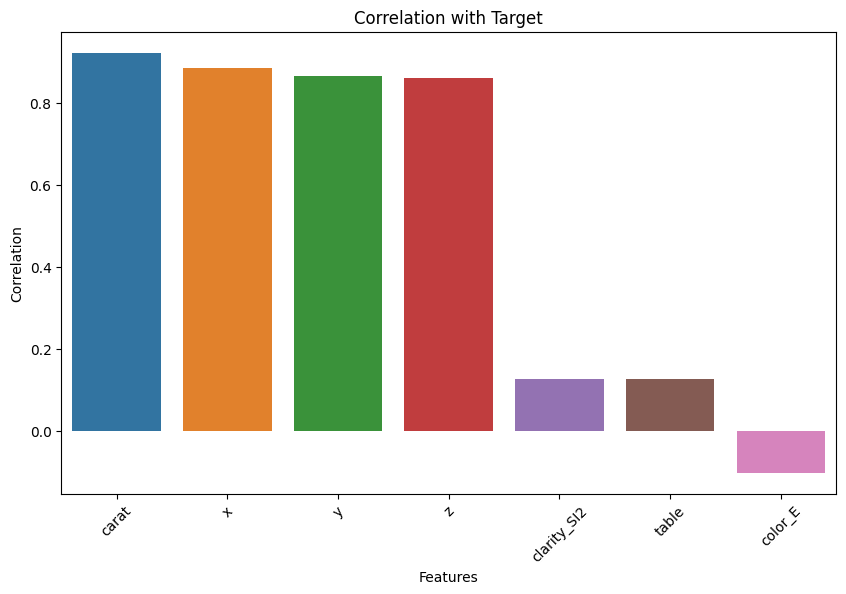

Selected Features:
carat          0.921591
x              0.884435
y              0.865421
z              0.861249
clarity_SI2    0.128420
table          0.127134
color_E       -0.101089
Name: price, dtype: float64


In [22]:
# Calculate correlations
correlations = data_encoded.corr()

# Correlation with the target variable ('price')
correlation_with_target = correlations['price'].sort_values(ascending=False)[1:]

# Plot a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlations, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Display correlation of each feature with the target variable
print(correlation_with_target)

correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) > correlation_threshold]

# Plot correlation values for selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=selected_features.index, y=selected_features)
plt.xticks(rotation=45)
plt.title('Correlation with Target')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

# List the selected features
print("Selected Features:")
print(selected_features)

6. Data Splitting for Model Training

In [23]:
def get_train_test_data(nn=False):
    if nn:
        # Data spliting
        X = data_encoded.drop(columns=['price'])
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
    X = data_encoded[selected_features.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

In [24]:
# other methods
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Make predictions on the training set
    train_predictions = model.predict(X_train)

    # Calculate mean absolute error and R2 score for the training set
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    # Make predictions on the test set
    test_predictions = model.predict(X_test)

    # Calculate mean absolute error and R2 score for the test set
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    # Print results
    print(f"Training Mean Absolute Error: {train_mae}")
    print(f"Training R2 Score: {train_r2}")
    print(f"Test Mean Absolute Error: {test_mae}")
    print(f"Test R2 Score: {test_r2}")
    return test_predictions

def visualize_predictions(y_test, test_predictions, plot_title):
    # Create a plot to visualize predicted prices vs. actual prices in the test set
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, test_predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(plot_title)
    plt.show()

## Learning Models

1. Linear Regression

Training Mean Absolute Error: 855.8573846326126
Training R2 Score: 0.8705290397140235
Test Mean Absolute Error: 847.2756995242472
Test R2 Score: 0.8712339868729347


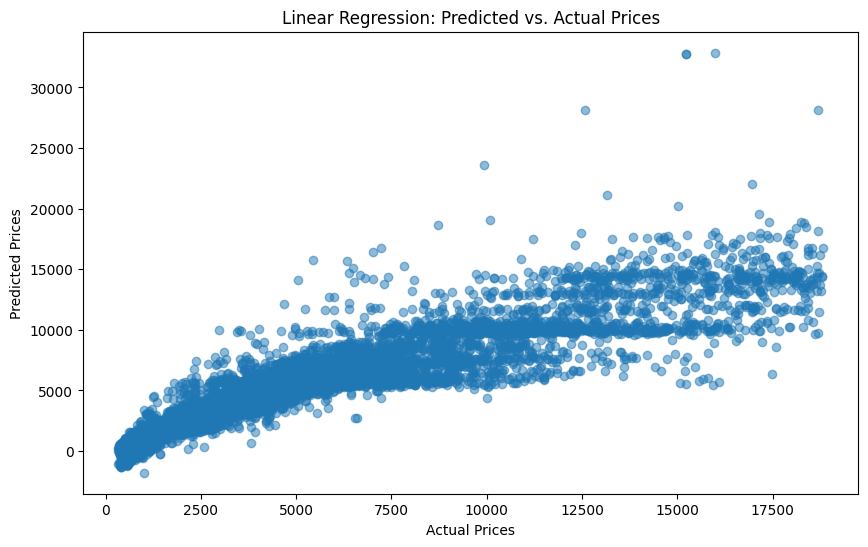

In [25]:
# Get data
X_train, X_test, y_train, y_test =  get_train_test_data()

# Initialize and train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

test_predictions = evaluate_model(lr_model, X_train, X_test, y_train, y_test)
visualize_predictions(y_test, test_predictions, 'Linear Regression: Predicted vs. Actual Prices')

2. Neural Network

Epoch 1/100
1180/1180 [==============================] - 2s 2ms/step - loss: 4012744.7500 - val_loss: 1841258.6250
Epoch 2/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2650365.0000 - val_loss: 1772283.1250
Epoch 3/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2725148.5000 - val_loss: 1835415.7500
Epoch 4/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2566694.0000 - val_loss: 1696165.1250
Epoch 5/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2479445.7500 - val_loss: 1699324.7500
Epoch 6/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2472959.2500 - val_loss: 1816398.5000
Epoch 7/100
1180/1180 [==============================] - 2s 1ms/step - loss: 2464301.7500 - val_loss: 1656684.0000
Epoch 8/100
1180/1180 [==============================] - 2s 2ms/step - loss: 2430382.5000 - val_loss: 1653874.1250
Epoch 9/100
1180/1180 [==============================] - 2s 1ms/step - loss: 244

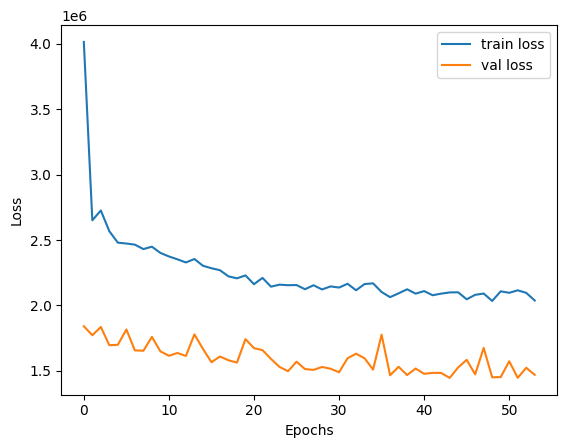

253/253 [==============================] - 0s 563us/step
Training Mean Absolute Error: 682.4887459354511
Training R2 Score: 0.9052883992525849
Test Mean Absolute Error: 678.2755440577723
Test R2 Score: 0.9057286264697988


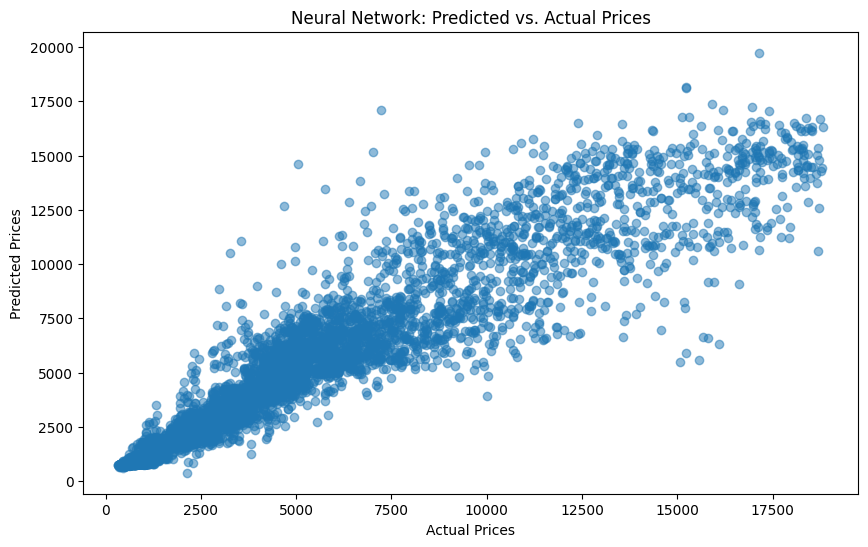

In [26]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = get_train_test_data(nn=True)

nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = nn_model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

test_predictions = evaluate_model(nn_model, X_train_scaled, X_test_scaled, y_train, y_test)
visualize_predictions(y_test, test_predictions, 'Neural Network: Predicted vs. Actual Prices')

3. Random Forest

Training Mean Absolute Error: 255.17929762436603
Training R2 Score: 0.9862013319023932
Test Mean Absolute Error: 676.2794298536288
Test R2 Score: 0.9004392273270793


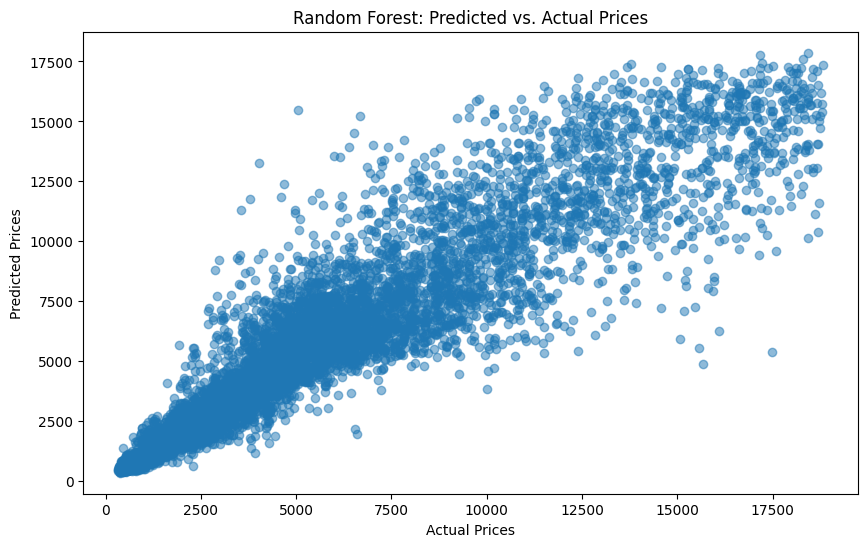

In [27]:
# Get data
X_train, X_test, y_train, y_test = get_train_test_data()

# Initialize and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

test_predictions = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
visualize_predictions(y_test, test_predictions, 'Random Forest: Predicted vs. Actual Prices')

## Parameter Tuning

1. Neural Network

In [28]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test = get_train_test_data(nn=True)

def create_model(hidden_layers=1, units=64, kernel_initializer='glorot_uniform', activation='relu'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    for _ in range(hidden_layers):
        model.add(tf.keras.layers.Dense(units, kernel_initializer=kernel_initializer, activation=activation))
        model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrap the Keras model using KerasRegressor
keras_regressor = KerasRegressor(model=create_model, verbose=0, hidden_layers=1, units=64, kernel_initializer='glorot_uniform', activation='relu')

# Define paramteres of model for grid search
param_grid = {
    'hidden_layers': [1, 2, 3, 4, 5, 6, 7],
    'units': [32, 64, 128],
    'kernel_initializer': ['glorot_uniform', 'he_normal'],
    'activation': ['relu', 'tanh']
}


grid = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_result = grid.fit(X_train_scaled, y_train)

# Print the best parameters and validation scores
print("Best Parameters: ", grid_result.best_params_)
print("Best Validation Score: ", grid_result.best_score_)

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Best Parameters:  {'activation': 'relu', 'hidden_layers': 5, 'kernel_initializer': 'glorot_uniform', 'units': 128}
Best Validation Score:  0.8685530194931061


2. Random Forest

In [29]:
X_train, X_test, y_train, y_test = get_train_test_data()

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]
}

# Initialize Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_['n_estimators']

# Initialize Random Forest model with the best n_estimators
best_rf_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)

# Fit the best model to the data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = best_rf_model.predict(X_test)

# Calculate mean absolute error on the test set
test_mae = mean_absolute_error(y_test, test_predictions)

# Print the best number of estimators and test MAE
print("Best Number of Estimators:", best_n_estimators)
print("Test Mean Absolute Error:", test_mae)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Number of Estimators: 300
Test Mean Absolute Error: 676.2794298536288


## Clustering

1. Choose best K using elbow method

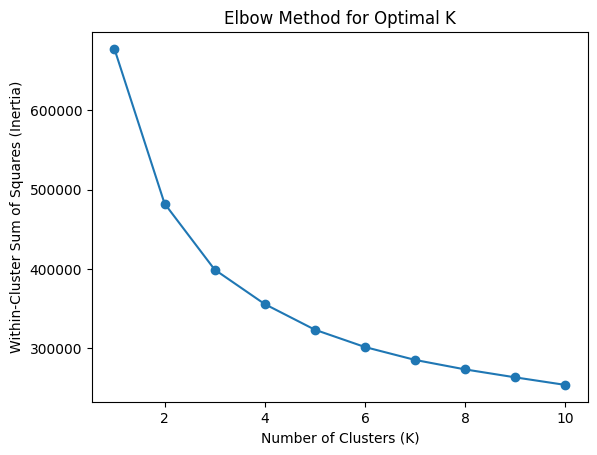

In [30]:
X = data_encoded.drop(columns=['price'])

# Calculate within-cluster sum of squares (inertia) for different values of K
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

2. Develop model

cluster
0    3014.592758
1    5304.379334
Name: price, dtype: float64


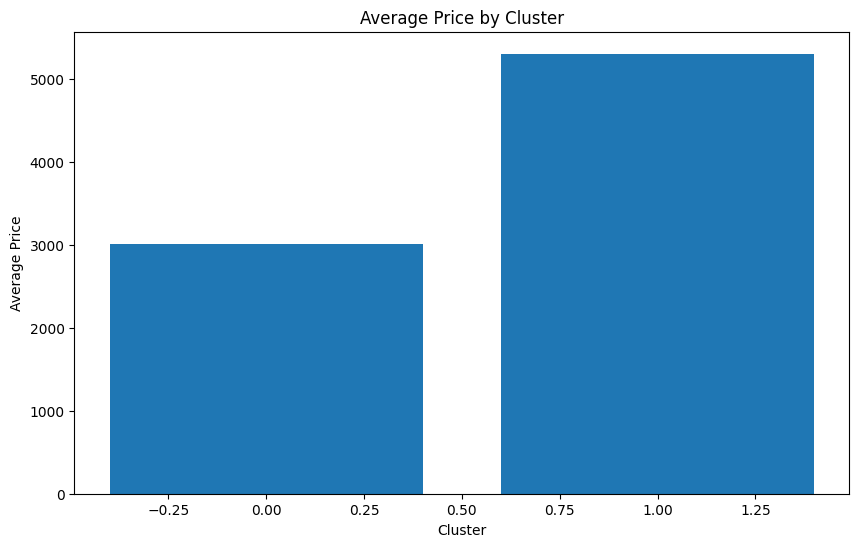

In [31]:
K = 2 # best K
kmeans = KMeans(n_clusters=K, random_state=42)

kmeans.fit(X)

# Add the cluster labels to the dataset
data_copy = df.copy(deep=True)
data_copy['cluster'] = kmeans.labels_

# Analyze the relationship between clusters and prices
cluster_prices = data_copy.groupby('cluster')['price'].mean()

# Print average price for each cluster
print(cluster_prices)

# Visualize the average prices for each cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_prices.index, cluster_prices.values)
plt.xlabel('Cluster')
plt.ylabel('Average Price')
plt.title('Average Price by Cluster')
plt.show()

## Results Analysis

In [32]:
X_train, X_test, y_train, y_test = get_train_test_data()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choose 3 random instances from the test set
random_indices = [10, 20, 30]  # Choose the indices accordingly
random_instances = X_test.iloc[random_indices]
actual_labels = y_test.iloc[random_indices]

# Predict labels using each model
lr_predictions = lr_model.predict(random_instances)
rf_predictions = rf_model.predict(random_instances)
nn_predictions = nn_model.predict(X_test_scaled[random_indices])

# Compare predicted labels with actual labels
lr_r2_score = r2_score(actual_labels, lr_predictions.round())
rf_r2_score = r2_score(actual_labels, rf_predictions.round())
nn_r2_score = r2_score(actual_labels, nn_predictions.round())

# Print the results
print("Linear Regression R2 score:", lr_r2_score)
print("Random Forest R2 score:", rf_r2_score)
print("Neural Network R2 score:", nn_r2_score)

1/1 [==============================] - 0s 36ms/step
Linear Regression R2 score: 0.9261112048667517
Random Forest R2 score: 0.972235339199738
Neural Network R2 score: 0.9505946910053915
